In [ ]:
# Importing Libraries
!pip install transformers
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, TFTrainer, TFTrainingArguments, DataCollatorWithPadding
import tensorflow as tf
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from matplotlib import pyplot as plt

In [ ]:

# Read Data 
df = pd.read_csv('/content/df_all.csv')
df.drop(columns=df.columns[0], axis=1, inplace=True)
df.head()

,text,class
0,rt crooked hillary you didn't lose because yo...,explicit_hate
1,"rt estonian pm : "" i don't want blacks in es...",explicit_hate
2,are a bunch of religious bigots . i hope you e...,explicit_hate
3,hamas is the only one who lies and all those l...,explicit_hate
4,one of the questions never asked : if africans...,explicit_hate


In [ ]:
# Check shape of dataframe 
df.shape

(64875, 2)

In [ ]:
# drop NA 
df = df.dropna()

In [ ]:
# Check distribution of classes
df['class'].value_counts()

not_hate         35977
offensive        19190
implicit_hate     7100
explicit_hate     2519
Name: class, dtype: int64

In [ ]:
# layers for multi class  classification 

# Copy Dataframe first
df_multiclass = df.copy()

# Replace classes 
df_multiclass['class'] = np.where((df_multiclass['class'] == 'not_hate'), 0, df_multiclass['class'])
df_multiclass['class'] = np.where((df_multiclass['class'] == 'offensive'), 1, df_multiclass['class'])
df_multiclass['class'] = np.where((df_multiclass['class'] == 'implicit_hate'), 2, df_multiclass['class'])
df_multiclass['class'] = np.where((df_multiclass['class'] == 'explicit_hate'), 3, df_multiclass['class'])

# show head 
df_multiclass.head()

,text,class
0,rt crooked hillary you didn't lose because yo...,3
1,"rt estonian pm : "" i don't want blacks in es...",3
2,are a bunch of religious bigots . i hope you e...,3
3,hamas is the only one who lies and all those l...,3
4,one of the questions never asked : if africans...,3


In [ ]:
# Show Distribution
df_multiclass['class'].value_counts()

0    35977
1    19190
2     7100
3     2519
Name: class, dtype: int64

In [ ]:

# Get max number of words 
num_words = df_multiclass['text'].apply(lambda x:len(str(x).split()))
print('The comment with the most words consist of', num_words.max(),'words')

The comment with the most words consist of 268 words


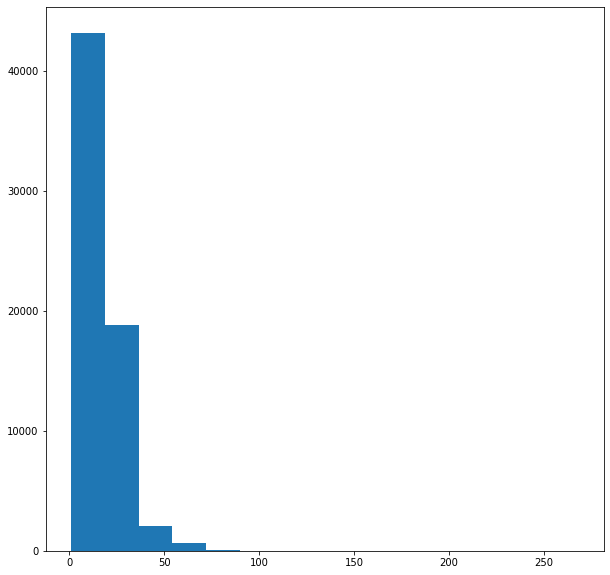

In [ ]:
# Visualize 
plt.hist(num_words, bins=15)
plt.show()

In [ ]:

# Create X  
X=list(df_multiclass['text']) 

# Create y 
y=list(df_multiclass['class']) 

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123) 

In [ ]:

categories=sorted(list(set(y))) #set will return the unique different entries

In [ ]:
num_categories = len(categories)
num_categories

4

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize X Train & Test Set 
train_input = tokenizer(X_train, truncation=True, padding=True, return_tensors='tf')
test_input = tokenizer(X_test, truncation=True, padding=True, return_tensors='tf')

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_input),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_input),
    y_test
))

In [ ]:
training_args = TFTrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps = 500,
    weight_decay=0.01,
    logging_steps=10,
    eval_steps = 10
)

In [ ]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score

In [ ]:
with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=num_categories)

trainer = TFTrainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=test_dataset
)

trainer.train()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_59', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
output = trainer.predict(test_dataset)[0]
output = np.argmax(output, axis = - 1)

In [ ]:
cm=confusion_matrix(y_test,output)
cm

array([[6604,   91,  445,   47],
       [  64, 3671,    7,   93],
       [ 571,    6,  813,   45],
       [  70,  161,  102,  168]])

In [ ]:
print(classification_report(y_test, output))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      7187
           1       0.93      0.96      0.95      3835
           2       0.59      0.57      0.58      1435
           3       0.48      0.34      0.39       501

    accuracy                           0.87     12958
   macro avg       0.73      0.69      0.71     12958
weighted avg       0.86      0.87      0.86     12958



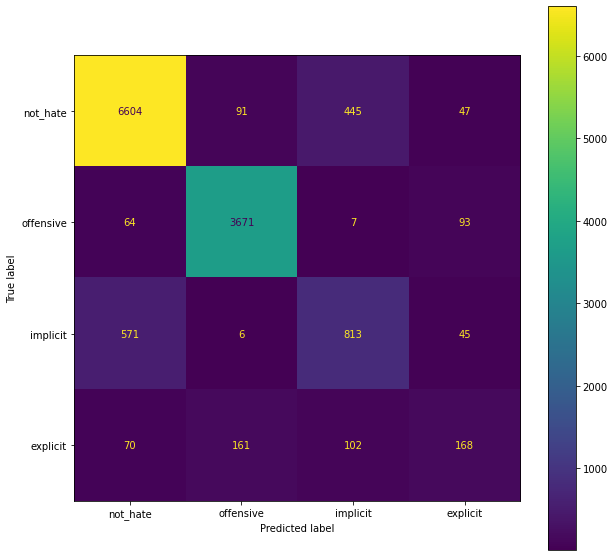

In [ ]:
from sklearn import metrics
plt.rcParams['figure.figsize'] = (10, 10)
confusion_matrix = metrics.confusion_matrix(y_test, output)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["not_hate", "offensive", "implicit", "explicit" ])

cm_display.plot()